# Importing necessary packages and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time
import os
import pickle
import joblib
import folium
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
# import warnings

# import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import (RandomForestRegressor,
                              GradientBoostingRegressor,
                              AdaBoostRegressor)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# for validation results
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold

In [2]:
# in this ml modeling section we will focus only on sale data
df = pd.read_csv('/content/drive/MyDrive/lun_real_estate_data.csv')
df = df[df['deal_type']=='Sale']
# no need animal column in sale df
df.drop(columns=['animal'], inplace=True)

In [5]:
# the same data like in EDA file after preprocessing
df.head(2)

,currency,city_name,main_area,second_area,street_name,subway,total_square,kitchen_square,living_square,rooms,total_floors,flat_floor,deal_type,newbuild_name,photo_counts,latitude,longitude,price_uah,is_newbuild
7610,$,Харків,Немишлянський,624 м.р.,Амосова вул. (Корчагінців),0,63.0,22.0,35.0,3.0,9,5,Sale,NaN,4,49.985256,36.345016,1250121.0,0
7611,$,Харків,Індустріальний,ХТЗ,Миру вул.,1,35.0,8.3,15.9,1.0,9,4,Sale,ЖК Миру-2,13,49.949810,36.379997,1875181.5,1


In [7]:
if df.duplicated().sum() > 0:
  df.drop_duplicates(inplace=True)

# Feature engineering

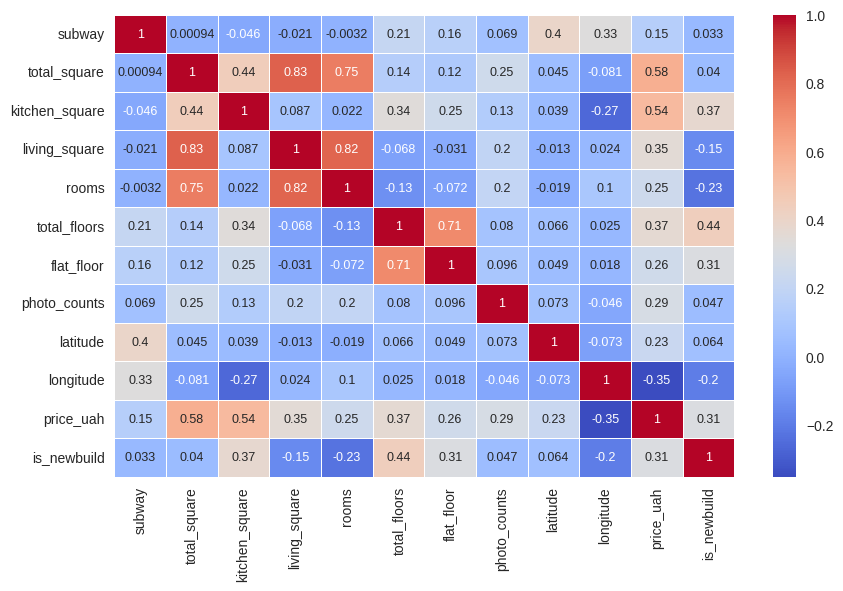

In [8]:
numeric_columns = df.select_dtypes(include='number').columns
# numeric_columns = numeric_columns.remove('animal')
corr_matrix = df[numeric_columns].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, annot_kws={"size": 9})
plt.show()

From this heatmap correlation map we see that factors have pretty big correlation which can make multicorrelation problems. We can make some research about that and see if multicorrelation exist and after remove factors with smaller effect on our target. But we just find factors with large correlation
(greater than 0.5) and remove one of them which less effect on target. So that is plan!

In [9]:
# let's finish like that
df = df[['price_uah', 'city_name', 'main_area', 'second_area', 'subway',
         'total_square', 'kitchen_square', 'total_floors',
         'photo_counts', 'latitude', 'longitude', 'is_newbuild']]

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24879 entries, 7610 to 32537
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   price_uah       24879 non-null  float64
 1   city_name       24879 non-null  object 
 2   main_area       20575 non-null  object 
 3   second_area     21551 non-null  object 
 4   subway          24879 non-null  int64  
 5   total_square    24879 non-null  float64
 6   kitchen_square  24879 non-null  float64
 7   total_floors    24879 non-null  int64  
 8   photo_counts    24879 non-null  int64  
 9   latitude        24805 non-null  float64
 10  longitude       24805 non-null  float64
 11  is_newbuild     24879 non-null  int64  
dtypes: float64(5), int64(4), object(3)
memory usage: 2.5+ MB


Let's check the data in more detail to understand its problems.

In [11]:
# first dataframe: cities with empty main area
empty_main_area = (
    df[df['main_area'].isna()]
    .value_counts(subset=['city_name'])
    .reset_index(name='empty_main_area')
)

# second dataframe: for those cities, count how many also have empty second_area
cities_with_empty_main_area = empty_main_area['city_name'].unique()

empty_second_area = (
    df[df['second_area'].isna() & df['city_name'].isin(cities_with_empty_main_area)]
    .value_counts(subset=['city_name'])
    .reset_index(name='empty_second_area')
)

# third dataframe: count all records per city
all_records = (
    df['city_name']
    .value_counts()
    .reset_index(name='total_records')
)

# fourth dataframe: number of unique second area by specific city
unique_second_area = (
    df[df['second_area'].notna() & df['city_name'].isin(cities_with_empty_main_area)]
    .groupby('city_name')['second_area']
    .nunique()
    .reset_index(name='unique_second_area')
)

summary = (
    empty_main_area
    .merge(empty_second_area, how='left', on='city_name')
    .merge(unique_second_area, how='left', on='city_name')
    .merge(all_records, how='left', on='city_name')
)

summary

,city_name,empty_main_area,empty_second_area,unique_second_area,total_records
0,Івано-Франківськ,1873,20,66,1873
1,Хмельницький,1260,48,58,1260
2,Тернопіль,553,96,53,553
3,Ужгород,309,53,53,309
4,Рівне,282,68,55,282
5,Луцьк,19,3,11,19
6,Черкаси,7,42,51,317
7,Київ,1,549,279,4879


We observe that some cities lack any administrative area data. Additionally, two cities have missing main area information, which necessitates their removal. While a potential solution was to utilize the second area data, this approach presents challenges. Firstly, the second area columns also contain missing values. Secondly, the large number of unique second areas within each city, with highly variable record counts (e.g., one area with 40 records, another with just one), would likely hinder the machine learning model's ability to identify meaningful patterns. Therefore, potential solutions include filling the missing main area values with the city name itself to see the impact, or using the coordinates to cluster the flats by location and incorporate these clusters into the modeling. Another approach would be to train the model separately for each city versus training a single model on all the data at once.

In [ ]:
# df = df.drop(columns='second_area')

## Making clusters by location (coordinates)

### Testing this approach

Firstly let's see how it works on one city.

In [12]:
df1 = df[df['city_name']=='Харків'].copy()
df1 = df1.dropna(subset='latitude')
# df1 = df1.drop(columns='main_area')

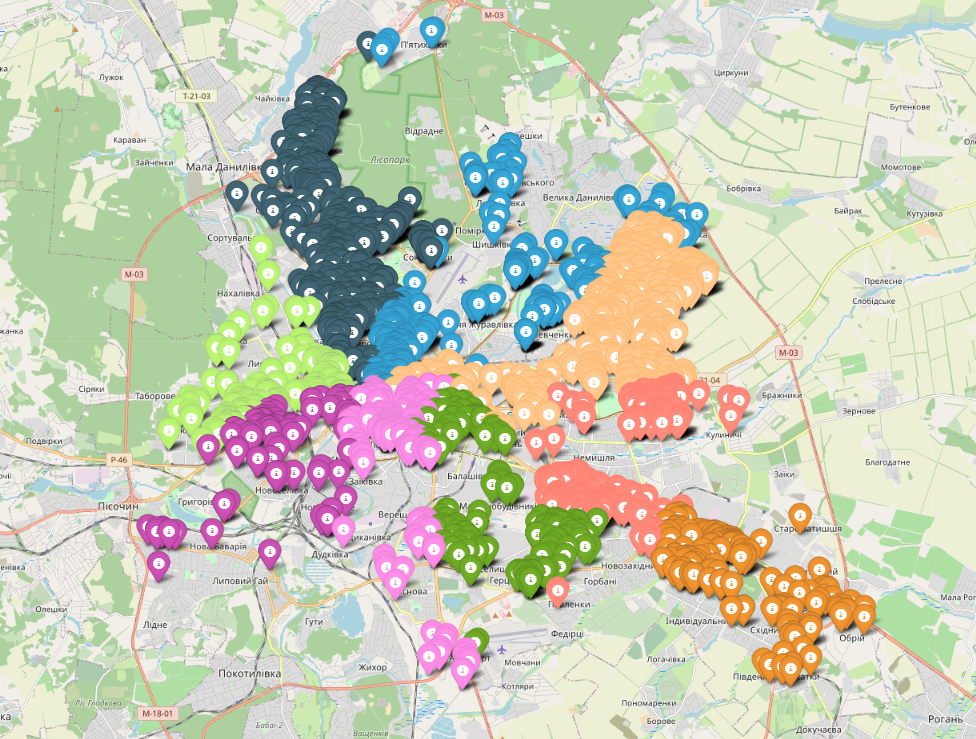

In [ ]:
# colors = ['lightred', 'orange', 'beige', 'lightgreen', 'green', 'cadetblue','blue', 'purple', 'pink']
# unique_main_areas = df1['main_area'].dropna().unique()
# color_map = {area: color for area, color in zip(unique_main_areas, colors)}

# kharkiv_map = folium.Map(location=[49.9935, 36.2304], zoom_start=12)

# for idx, row in df1[["latitude", "longitude", "price_uah", "main_area"]].dropna().iterrows():
#     area = row["main_area"]
#     color = color_map.get(area, "gray")
#     folium.Marker(
#         [row["latitude"], row["longitude"]],
#         popup=f"House {idx}, Price: {row['price_uah']}, Area: {area}",
#         icon=folium.Icon(color=color)
#     ).add_to(kharkiv_map)

# kharkiv_map

# using PIL to get image of the code result above
img = Image.open(r"/content/kharkiv_areas.png")
img

See that we have "correct" flat distribution by main areas in Kharkiv, but what if this don't give us maximum info of specific area which can't effect on target price significantly.

In [17]:
# using only standardized parameters of location for making clusters
scaler = StandardScaler()
x_std = pd.DataFrame(scaler.fit_transform(df1[df1['city_name']=='Харків'][["latitude", "longitude"]]), columns=df1[df1['city_name']=='Харків'][["latitude", "longitude"]].columns)

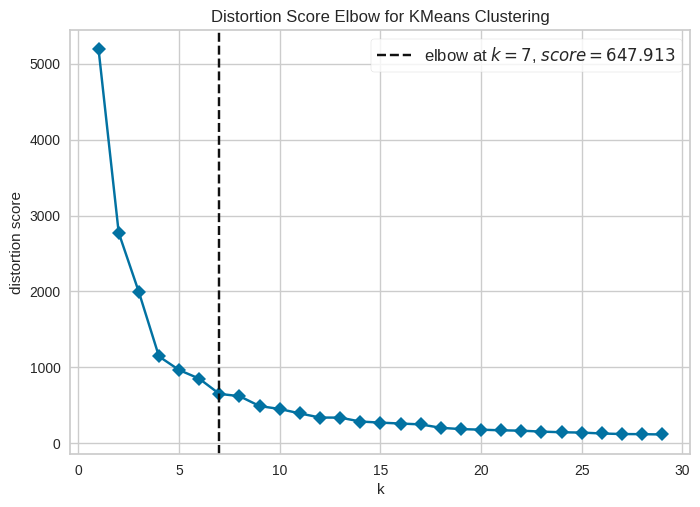

In [19]:
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(1,30), timings=False)
visualizer.fit(x_std)
visualizer.show()
plt.show()

In [20]:
k_means = KMeans(init = "k-means++", n_clusters=7, n_init=12, random_state=42)
k_means.fit(x_std)
labels = k_means.labels_

In [21]:
clus_df = df1.copy()
clus_df["cluster"] = labels
clus_df.head()

,price_uah,city_name,main_area,second_area,subway,total_square,kitchen_square,total_floors,photo_counts,latitude,longitude,is_newbuild,cluster
7610,1250121.00,Харків,Немишлянський,624 м.р.,0,63.0,22.0,9,4,49.985256,36.345016,0,2
7611,1875181.50,Харків,Індустріальний,ХТЗ,1,35.0,8.3,9,13,49.949810,36.379997,1,3
7612,833414.00,Харків,Немишлянський,624 м.р.,0,31.5,6.2,9,10,49.986767,36.347069,0,2
7613,1458474.50,Харків,Салтівський,NaN,1,50.3,7.9,5,20,49.989243,36.242268,0,6
7614,854249.35,Харків,Немишлянський,Стадіон ХТЗ,1,40.0,15.3,7,18,49.954735,36.350838,0,3


In [22]:
clus_df.groupby('cluster').agg({'main_area':'unique', 'latitude':'mean', 'longitude':'mean'}).reset_index()

,cluster,main_area,latitude,longitude
0,0,"[Шевченківський, Київський, Холодногірський]",50.021442,36.229698
1,1,"[Слобідський, Немишлянський, Основ'янський, Са...",49.952397,36.302220
2,2,"[Немишлянський, Салтівський, Київський]",50.010295,36.339316
3,3,"[Індустріальний, Немишлянський]",49.940660,36.387300
4,4,"[Холодногірський, Новобаварський, Основ'янський]",49.980915,36.183407
5,5,"[Шевченківський, Київський]",50.057427,36.218488
6,6,"[Салтівський, Київський, Основ'янський, Слобід...",49.988500,36.246184


See that different areas exist in different clusters, which not really surprise to much, because administrative areas not the same like mathematical optimal clusters.

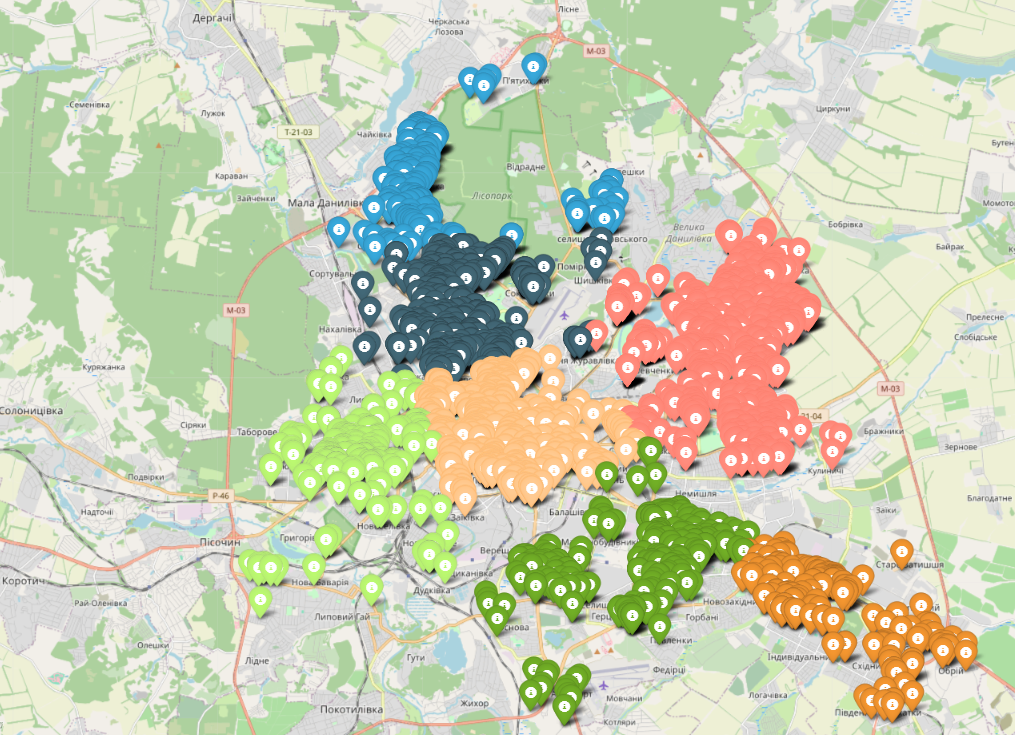

In [25]:
# colors = ['lightred', 'orange', 'beige', 'lightgreen', 'green', 'cadetblue','blue']
# unique_clusters = clus_df['cluster'].dropna().unique()
# color_map = {cluster: color for cluster, color in zip(unique_clusters, colors)}

# kharkiv_map = folium.Map(location=[49.9935, 36.2304], zoom_start=12)

# for idx, row in clus_df[["latitude", "longitude", "price_uah", "cluster"]].dropna().iterrows():
#     cluster = row["cluster"]
#     color = color_map.get(cluster, "gray")
#     folium.Marker(
#         [row["latitude"], row["longitude"]],
#         popup=f"House {idx}, Price: {row['price_uah']}, Cluster: {cluster}",
#         icon=folium.Icon(color=color)
#     ).add_to(kharkiv_map)

# kharkiv_map

# using PIL to get image of the code result above
img = Image.open(r"/content/kharkiv_clusters.png")
img

The image shows a more accurate mathematical clustering of flats compared to the original administrative areas. This approach, in my opinion, is more meaningful as it clearly identifies the city center, where flats are more expensive, and other suburban areas with their distinct characteristics. However, this presents a challenge for deploying a machine learning model in production. Users are unlikely to input exact coordinates; they will likely provide a main area name or perhaps a second area name, which we need to consider. So let's see if second areas exist within different clusters of this example.

In [26]:
temp_df = clus_df.groupby('cluster').agg({'main_area':'unique', 'second_area':'unique'}).reset_index()
temp_df

,cluster,main_area,second_area
0,0,"[Шевченківський, Київський, Холодногірський]","[Шатилівка, nan, Журавлівка, Павлове поле, 6 м..."
1,1,"[Слобідський, Немишлянський, Основ'янський, Са...","[841 м.р., Нові будинки, Одеська, ЦНАП, nan, 2..."
2,2,"[Немишлянський, Салтівський, Київський]","[624 м.р., 535-А м.р., 656 м.р., Салтівка, 524..."
3,3,"[Індустріальний, Немишлянський]","[ХТЗ, Стадіон ХТЗ, nan, Східний, Медичний цент..."
4,4,"[Холодногірський, Новобаварський, Основ'янський]","[Залопань, Панасівка, Гончарівка, Рубанівка, п..."
5,5,"[Шевченківський, Київський]","[Олексіївка, Зелене, 338 м.р., 337 м.р., Помір..."
6,6,"[Салтівський, Київський, Основ'янський, Слобід...","[nan, Нагірний, Молодіжний парк, Кінотеатр ""Pa..."


In [27]:
values_counter = {}

for row in temp_df.itertuples():
  second_areas = row.second_area
  if isinstance(second_areas, np.ndarray):
    for value in second_areas:
      if pd.notna(value):
        clean_val = value.strip()
        if values_counter.get(clean_val, None) is None:
          values_counter[clean_val]=1
        else:
          values_counter[clean_val]+=1

duplicates_area = {val: count for val, count in values_counter.items() if count > 1}

duplicates_area

{'Журавлівка': 3,
 'Павлове поле': 2,
 'Лісопарк': 2,
 '4 м.р.': 2,
 '5 м.р.': 2,
 'Харківський зоопарк': 2,
 'Нагірний': 2,
 'Молодіжний парк': 2,
 'Шишківка': 2,
 'Локомотив': 2,
 'Лиса гора': 2,
 '337 м.р.': 2,
 'Нові будинки': 2,
 'Перше Салтівське селище': 3,
 'Архангело-Михайлівський храм': 2,
 'Левада': 2,
 'Стадіон ХТЗ': 2,
 'Основа': 2,
 'Стара Салтівка': 2,
 'стадіон Металіст': 2,
 'Червоний промінь': 2,
 'Жуковського': 3,
 'Новожаново': 2,
 'Сабурова дача': 2,
 'ТРЦ Французький бульвар': 2,
 'Залопань': 2,
 'Панасівка': 2}

We observe that we are encountering duplicate second area entries within our second_area column for each cluster. This suggests that to accurately identify clusters, coordinates alone are sufficient for good performance, rendering second_area names unnecessary. This approach is indeed preferable as it offers a more robust solution, particularly because our dataset does not contain all possible second area names for each city.

### Making cluster algorithm for all data

In [28]:
data = df.copy()
data.dropna(subset='latitude', inplace=True)

In [29]:
data['city_name'].value_counts().reset_index()

,city_name,count
0,Київ,4866
1,Одеса,4418
2,Харків,2595
3,Львів,2369
4,Івано-Франківськ,1873
5,Дніпро,1860
6,Хмельницький,1260
7,Запоріжжя,752
8,Кривий Ріг,587
9,Тернопіль,553


In [30]:
data = data[~(data['city_name']=='Луцьк')]

In [31]:
final_dataframe = pd.DataFrame()
# scaler = StandardScaler()
model = KMeans(random_state=42)
cluster_models_per_city = {}
scalers_per_city = {}
optimal_num_of_clusters_per_city = {}

unique_cities = data['city_name'].unique()
for city in unique_cities:
  dataframe_part = data[data['city_name']==city].copy()

  scaler = StandardScaler()
  location_std = pd.DataFrame(
      scaler.fit_transform(dataframe_part[["latitude", "longitude"]]),
      columns=dataframe_part[["latitude", "longitude"]].columns
      )

  scalers_per_city[city] = scaler
  visualizer = KElbowVisualizer(model, k=(1,40), timings=False)
  visualizer.fit(location_std)
  optimal_k = visualizer.elbow_value_
  optimal_num_of_clusters_per_city[city] = optimal_k

  if optimal_k is None:
        optimal_k = 1

  k_means = KMeans(init = "k-means++", n_clusters=optimal_k, n_init=12, random_state=42)
  k_means.fit(location_std)
  cluster_models_per_city[city] = k_means
  labels = k_means.labels_

  dataframe_part["cluster"] = labels
  final_dataframe = pd.concat([final_dataframe, dataframe_part], axis=0, ignore_index=True)
# plt.title('Automatically determine the optimal number of clusters using the elbow method')
# plt.show()
plt.close()

In [32]:
optimal_num_of_clusters_per_city

{'Харків': np.int64(7),
 'Київ': np.int64(6),
 'Львів': np.int64(6),
 'Дніпро': np.int64(7),
 'Одеса': np.int64(5),
 'Кропивницький': np.int64(8),
 'Полтава': np.int64(8),
 'Івано-Франківськ': np.int64(7),
 'Вінниця': np.int64(6),
 'Ужгород': np.int64(7),
 'Рівне': np.int64(6),
 'Чернігів': np.int64(7),
 'Тернопіль': np.int64(7),
 'Чернівці': np.int64(7),
 'Житомир': np.int64(4),
 'Хмельницький': np.int64(7),
 'Черкаси': np.int64(8),
 'Миколаїв': np.int64(6),
 'Запоріжжя': np.int64(8),
 'Суми': np.int64(7),
 'Кривий Ріг': np.int64(6)}

For future ml deployment, I'm unsure of the best way to save these results. I could simply store the cluster centroids and then determine the cluster by finding the minimum Euclidean distance. Alternatively, I could save and use each specific model trained for each individual city.

In [33]:
centroids = cluster_models_per_city['Харків'].cluster_centers_

example_coordinates = [49.984758, 36.233236]

specific_scaler = scalers_per_city['Харків']
scaled_coords = specific_scaler.transform([example_coordinates])

# using simple and manual algorithm for searching minimal euclidian distance
euclidean_distances = []
for centroid in centroids:
  dist = np.linalg.norm(scaled_coords-centroid)
  euclidean_distances.append(dist)

print('Location cluster for coordinates: ', np.argmin(euclidean_distances))

# model usage
print('Location cluster for coordinates: ', cluster_models_per_city['Харків'].predict(scaled_coords)[0])

Location cluster for coordinates:  6
Location cluster for coordinates:  6


In [35]:
# save kmeans model and specific scales for that
root_path_model = '/content/cluster_models_per_city'

for city, model in cluster_models_per_city.items():
  full_path = '{}/{}'.format(root_path_model, city)
  with open(f'{full_path}.pkl','wb') as f:
    pickle.dump(model, f)

root_path_model = '/content/scale_models_per_city'

for city, model in scalers_per_city.items():
  full_path = '{}/{}'.format(root_path_model, city)
  with open(f'{full_path}.pkl','wb') as f:
    pickle.dump(model, f)

In [36]:
city_cluster_areas = final_dataframe.groupby(['city_name', 'cluster'])['second_area'].unique().reset_index()
new_rows = []

for row in city_cluster_areas.itertuples():
  # new_records = []
  second_areas = row.second_area
  if isinstance(second_areas, np.ndarray):
    new_record = ', '.join(value for value in second_areas if pd.notna(value))
    new_rows.append(new_record)

city_cluster_areas['second_area'] = new_rows

In [37]:
city_cluster_areas.to_csv('clusters_by_city_and_second_location.csv', index=False)

In [38]:
final_dataframe['location'] = final_dataframe['city_name'] + ' ' + final_dataframe['cluster'].astype(str)

In [39]:
final_dataframe.head()

,price_uah,city_name,main_area,second_area,subway,total_square,kitchen_square,total_floors,photo_counts,latitude,longitude,is_newbuild,cluster,location
0,1250121.00,Харків,Немишлянський,624 м.р.,0,63.0,22.0,9,4,49.985256,36.345016,0,2,Харків 2
1,1875181.50,Харків,Індустріальний,ХТЗ,1,35.0,8.3,9,13,49.949810,36.379997,1,3,Харків 3
2,833414.00,Харків,Немишлянський,624 м.р.,0,31.5,6.2,9,10,49.986767,36.347069,0,2,Харків 2
3,1458474.50,Харків,Салтівський,NaN,1,50.3,7.9,5,20,49.989243,36.242268,0,6,Харків 6
4,854249.35,Харків,Немишлянський,Стадіон ХТЗ,1,40.0,15.3,7,18,49.954735,36.350838,0,3,Харків 3


In [40]:
categorical_columns = ['location']
columns_to_drop = ['city_name',	'main_area', 'second_area', 'cluster', 'location']

dummies = pd.get_dummies(final_dataframe[categorical_columns], dtype=float)
preprocessed_data = pd.concat([final_dataframe.drop(columns=columns_to_drop), dummies], axis=1) # drop_first=True

# Building ML models

## Classic ML models building and estimation

In [41]:
y = preprocessed_data['price_uah']
X = preprocessed_data.drop(columns='price_uah')

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(19828, 148)
(19828,)
(4958, 148)
(4958,)


In [43]:
X_train.columns = X_train.columns.str.replace(r'[^\w]', '_', regex=True)
X_test.columns = X_test.columns.str.replace(r'[^\w]', '_', regex=True)

In [44]:
# saving columns view for further custom modeling
joblib.dump(X_train.columns.tolist(), "columns_for_modeling.pkl")

['columns_for_modeling.pkl']

In [45]:
random_state = 42

models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=random_state),
    'Random Forest': RandomForestRegressor(random_state=random_state),
    'SVR': SVR(),
    'LightGBM': lgb.LGBMRegressor(verbose=-1),
    'XGBoost': xgb.XGBRegressor(random_state=random_state),
    'Gradient Boosting Regressor' : GradientBoostingRegressor(random_state=random_state),
    'ADA Boost' : AdaBoostRegressor(random_state=random_state),
    'Linear SVR' : LinearSVR(random_state=random_state),
}

evaluation_df = pd.DataFrame({
    'Model': [],
    'MSE': [],
    'MAE': [],
    'R-squared': [],
    'R-squared-for_train': [],
    'MAE train': []
})

for name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()

    pred = model.predict(X_test)
    pred_train = model.predict(X_train)

    training_time = end_time - start_time
    print(f"{name} training is finished")
    print(f"Spended time - {training_time}")
    print("~"*20)
    print("\n")

    mse = mean_squared_error(y_test, pred)
    mae = mean_absolute_error(y_test, pred)
    r_squared = r2_score(y_test, pred)
    r_squared_train = r2_score(y_train, pred_train)
    mae_train = mean_absolute_error(y_train, pred_train)

    new_row = pd.DataFrame({
        'Model': [name],
        'MSE': [mse],
        'MAE': [mae],
        'R-squared': [r_squared],
        'R-squared-for_train': [r_squared_train],
        'MAE train': [mae_train]
    })

    evaluation_df = pd.concat([evaluation_df, new_row], ignore_index=True)

Linear Regression training is finished
Spended time - 0.3141911029815674
~~~~~~~~~~~~~~~~~~~~


Decision Tree training is finished
Spended time - 0.4345211982727051
~~~~~~~~~~~~~~~~~~~~


Random Forest training is finished
Spended time - 32.397461891174316
~~~~~~~~~~~~~~~~~~~~


SVR training is finished
Spended time - 90.47063040733337
~~~~~~~~~~~~~~~~~~~~


LightGBM training is finished
Spended time - 0.4169430732727051
~~~~~~~~~~~~~~~~~~~~


XGBoost training is finished
Spended time - 1.0903992652893066
~~~~~~~~~~~~~~~~~~~~


Gradient Boosting Regressor training is finished
Spended time - 6.764817476272583
~~~~~~~~~~~~~~~~~~~~


ADA Boost training is finished
Spended time - 8.256751298904419
~~~~~~~~~~~~~~~~~~~~


Linear SVR training is finished
Spended time - 0.047197580337524414
~~~~~~~~~~~~~~~~~~~~




In [46]:
evaluation_df.sort_values(by='MSE', ascending=True)

,Model,MSE,MAE,R-squared,R-squared-for_train,MAE train
2,Random Forest,4.095663e+11,4.541731e+05,0.784261,0.971179,1.652431e+05
5,XGBoost,4.117143e+11,4.689842e+05,0.783130,0.873141,3.649617e+05
4,LightGBM,4.190416e+11,4.759704e+05,0.779270,0.825531,4.295435e+05
6,Gradient Boosting Regressor,5.039246e+11,5.263937e+05,0.734558,0.755315,5.083237e+05
0,Linear Regression,5.658520e+11,5.520614e+05,0.701938,0.730488,5.362226e+05
1,Decision Tree,8.004499e+11,5.946568e+05,0.578363,0.999994,1.358311e+02
8,Linear SVR,1.034925e+12,7.447428e+05,0.454854,0.470049,7.343808e+05
7,ADA Boost,1.076780e+12,8.992022e+05,0.432807,0.449638,8.931378e+05
3,SVR,1.983542e+12,1.079638e+06,-0.044830,-0.037314,1.080444e+06


We observe a good improvement in the results. Before preparing this notebook, my best model achieved a Mean Absolute Error (MAE) of 4.963914e+05 and an R-squared (R²) of 0.757081. Random Forest shows the best metrics, but its training is very time-consuming. Therefore, XGBoost is a strong second choice in the rating, and it also exhibits less overfitting.

## Cross validation for specific model

In [47]:
# cross validation for XGBoost model and see what average metrics we have

best_model = xgb.XGBRegressor(random_state=random_state)

kf = KFold(n_splits=10, shuffle=True, random_state=42)

kf_score_r2 = cross_val_score(best_model, X, y, cv=kf, scoring="r2")
kf_score_mae = cross_val_score(best_model, X, y, cv=kf, scoring="neg_mean_absolute_error")

print(f"Cross validation average R2 score: {np.average(kf_score_r2)}")
print(f"Cross validation average MAE score : {np.abs(np.average(kf_score_mae))}")

Cross validation average R2 score: 0.791876336673162
Cross validation average MAE score : 458947.3538190949


## Model tuning and regularization

In [ ]:
param_grid = {
    'n_estimators': [100, 150],
    'learning_rate': [0.05, 0.1],
    'max_depth': [5, 7],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'alpha': [0, 0.5, 1],
    'lambda': [1, 1.5, 2]
}

grid_search = GridSearchCV(estimator=best_model, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)
print("Best parameters found: ", grid_search.best_params_)

best_model_tunning = grid_search.best_estimator_
y_pred = best_model_tunning.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R2 score: {r2}")

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best parameters found:  {'alpha': 0.5, 'colsample_bytree': 0.7, 'lambda': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 150, 'subsample': 0.8}
Mean Squared Error: 370596395489.45795
R2 score: 0.7939526882304914


In [ ]:
y_pred_tun = best_model_tunning.predict(X_test)

# Evaluate the best model on the test set
mse_tun = mean_squared_error(y_test, y_pred_tun)
print(f"Mean Squared Error of the best model: {mse_tun}")
mae_tun = mean_absolute_error(y_test, y_pred_tun)
print(f"Mean Absolute Error of the best model: {mae_tun}")
r2_tun = r2_score(y_test, y_pred_tun)
print(f"R2 of the best model: {r2_tun}")

Mean Squared Error of the best model: 370596395489.45795
Mean Absolute Error of the best model: 445940.01125827647
R2 of the best model: 0.7939526882304914


In [ ]:
with open('best_sale_deal_model.pkl','wb') as f:
  pickle.dump(best_model_tunning, f)

# Making final preparation for custom model usage

But what if a user provides their own custom data and wants to predict the sale price of a flat on the market?

In [48]:
def load_kmeans_model(picked_city: str, models_path: str):
  kmeans_model_name = None
  for model_name in os.listdir(models_path):
    if picked_city in model_name:
      kmeans_model_name = model_name
      break
  if kmeans_model_name is None:
    return None

  kmeans_model = pickle.load(open(f'{models_path}/{kmeans_model_name}', 'rb'))
  return kmeans_model


def load_scaler_model(picked_city: str, scalers_path: str):
  scaler_model_name = None
  for model_name in os.listdir(scalers_path):
    if picked_city in model_name:
      scaler_model_name = model_name
      break

  if scaler_model_name is None:
    return None

  scaler_model = pickle.load(open(f'{scalers_path}/{scaler_model_name}', 'rb'))
  return scaler_model


def get_prediction_for_custom_data(picked_city: str, subway: int,
                                   total_square: float, kitchen_square: float,
                                   total_floors: int, photo_counts: int,
                                   latitude: float, longitude: float,
                                   is_newbuild: int, model, necessary_columns,
                                   scaler_model, kmeans_model):

  scaled_coordinates = scaler_model.transform([[latitude, longitude]])
  cluster = kmeans_model.predict(scaled_coordinates)[0]

  col_name = f'location_{picked_city} {cluster}'
  temp_dataset = pd.DataFrame({'location': [col_name]})
  location_col = pd.get_dummies(temp_dataset['location'], dtype=float)

  input_dataset = pd.DataFrame({'subway':[subway], 'total_square':[total_square],
                                'kitchen_square':[kitchen_square], 'total_floors':[total_floors],
                                'photo_counts': [photo_counts], 'latitude': [latitude],
                                'longitude': [longitude], 'is_newbuild': [is_newbuild]})

  new_dummies_aligned = location_col.reindex(columns=necessary_columns, fill_value=0)
  new_dummies_aligned = new_dummies_aligned.iloc[:, 8:]
  new_input = pd.concat([input_dataset, new_dummies_aligned], axis=1)

  return model.predict(new_input)

In [50]:
picked_city = 'Харків'

model = pickle.load(open('/content/best_sale_deal_model.pkl', 'rb'))
necessary_columns = joblib.load("/content/columns_for_modeling.pkl")

scaler_model = load_scaler_model(picked_city, '/content/scale_models_per_city')
kmeans_model = load_kmeans_model(picked_city, '/content/cluster_models_per_city')

predicted_price = get_prediction_for_custom_data(picked_city=picked_city,
                                                 subway=1,
                                                 total_square=64,
                                                 kitchen_square=7,
                                                 total_floors=12,
                                                 photo_counts=10,
                                                 latitude=50.060753,
                                                 longitude=36.201721,
                                                 is_newbuild=1,
                                                 model=model,
                                                 necessary_columns=necessary_columns,
                                                 scaler_model=scaler_model,
                                                 kmeans_model=kmeans_model)

print(f'Custom predicted price for falt: {predicted_price}')

Custom predicted price for falt: [1875741.6]


DONE